# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.9220227537643275 -2.5970852063973986
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [35]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [50]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    gloss = tf.reduce_mean(neg_log_prob_actions * Qs)
    #dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.square(Qs - targetQs))
    # dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(dQs, shape=[-1]),
    #                                                                labels=tf.nn.sigmoid(targetQs)))
    return actions_logits, Qs, gloss, dloss

In [51]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [52]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [53]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [54]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1000, 4) actions:(1000,)
action size:1


In [55]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
# state_size = 37
# state_size_ = (84, 84, 3)
state_size = 4
action_size = 2
hidden_size = 64             # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
gamma = 0.99                   # future reward discount
memory_size = 1000            # memory capacity
batch_size = 1000             # experience mini-batch size

In [56]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [57]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [58]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            #batch = memory.sample(batch_size)
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0 gloss:0.0498 dloss:1.0023 exploreP:0.9986
Episode:1 meanR:13.0000 R:12.0 gloss:0.0854 dloss:1.0046 exploreP:0.9974
Episode:2 meanR:20.0000 R:34.0 gloss:0.1542 dloss:1.0173 exploreP:0.9941
Episode:3 meanR:23.2500 R:33.0 gloss:0.2718 dloss:1.0568 exploreP:0.9908
Episode:4 meanR:23.6000 R:25.0 gloss:0.3915 dloss:1.1077 exploreP:0.9884
Episode:5 meanR:24.6667 R:30.0 gloss:0.5213 dloss:1.1752 exploreP:0.9855
Episode:6 meanR:25.0000 R:27.0 gloss:0.6723 dloss:1.2614 exploreP:0.9828
Episode:7 meanR:25.1250 R:26.0 gloss:0.8312 dloss:1.3513 exploreP:0.9803
Episode:8 meanR:24.5556 R:20.0 gloss:0.9957 dloss:1.4476 exploreP:0.9784
Episode:9 meanR:23.6000 R:15.0 gloss:1.1360 dloss:1.5383 exploreP:0.9769
Episode:10 meanR:23.1818 R:19.0 gloss:1.2858 dloss:1.6425 exploreP:0.9751
Episode:11 meanR:22.5000 R:15.0 gloss:1.4484 dloss:1.7601 exploreP:0.9736
Episode:12 meanR:23.9231 R:41.0 gloss:1.7379 dloss:1.9584 exploreP:0.9697
Episode:13 meanR:23.7143 R:21.0 gloss:2.1098 dlo

Episode:109 meanR:28.2700 R:14.0 gloss:13.6700 dloss:16.3256 exploreP:0.7388
Episode:110 meanR:28.2800 R:20.0 gloss:13.4496 dloss:15.9058 exploreP:0.7373
Episode:111 meanR:28.5300 R:40.0 gloss:13.1405 dloss:15.5194 exploreP:0.7344
Episode:112 meanR:28.5200 R:40.0 gloss:13.2882 dloss:15.4409 exploreP:0.7316
Episode:113 meanR:28.5200 R:21.0 gloss:13.4864 dloss:15.7947 exploreP:0.7300
Episode:114 meanR:28.7700 R:41.0 gloss:13.5317 dloss:15.6984 exploreP:0.7271
Episode:115 meanR:28.4400 R:24.0 gloss:13.7857 dloss:16.1161 exploreP:0.7254
Episode:116 meanR:29.1700 R:93.0 gloss:13.8097 dloss:16.0012 exploreP:0.7188
Episode:117 meanR:29.2800 R:22.0 gloss:14.0628 dloss:16.7861 exploreP:0.7172
Episode:118 meanR:29.2700 R:39.0 gloss:13.8052 dloss:16.2392 exploreP:0.7144
Episode:119 meanR:29.4200 R:60.0 gloss:13.9096 dloss:16.2681 exploreP:0.7102
Episode:120 meanR:29.2700 R:10.0 gloss:14.2267 dloss:17.1978 exploreP:0.7095
Episode:121 meanR:29.3100 R:16.0 gloss:14.1021 dloss:17.3070 exploreP:0.7084

Episode:216 meanR:22.2700 R:25.0 gloss:11.1680 dloss:14.4451 exploreP:0.5773
Episode:217 meanR:22.4000 R:35.0 gloss:11.1675 dloss:14.4903 exploreP:0.5753
Episode:218 meanR:22.2400 R:23.0 gloss:11.1812 dloss:14.3294 exploreP:0.5740
Episode:219 meanR:21.7600 R:12.0 gloss:11.2560 dloss:14.3920 exploreP:0.5733
Episode:220 meanR:21.8900 R:23.0 gloss:11.1899 dloss:14.2695 exploreP:0.5720
Episode:221 meanR:22.0900 R:36.0 gloss:11.2652 dloss:14.4374 exploreP:0.5700
Episode:222 meanR:22.1000 R:17.0 gloss:11.2506 dloss:14.7589 exploreP:0.5690
Episode:223 meanR:22.3600 R:40.0 gloss:11.1015 dloss:14.2785 exploreP:0.5668
Episode:224 meanR:22.5300 R:29.0 gloss:11.2654 dloss:14.6779 exploreP:0.5652
Episode:225 meanR:22.7300 R:33.0 gloss:11.2128 dloss:14.6795 exploreP:0.5634
Episode:226 meanR:22.8200 R:26.0 gloss:11.2194 dloss:14.6276 exploreP:0.5619
Episode:227 meanR:22.9200 R:28.0 gloss:11.4308 dloss:14.8652 exploreP:0.5604
Episode:228 meanR:23.0000 R:23.0 gloss:11.4359 dloss:15.0498 exploreP:0.5591

Episode:323 meanR:26.0600 R:51.0 gloss:11.1580 dloss:16.1202 exploreP:0.4391
Episode:324 meanR:26.1700 R:40.0 gloss:11.4758 dloss:16.5878 exploreP:0.4374
Episode:325 meanR:26.1500 R:31.0 gloss:11.3939 dloss:16.5521 exploreP:0.4360
Episode:326 meanR:26.0700 R:18.0 gloss:11.2703 dloss:16.6934 exploreP:0.4353
Episode:327 meanR:26.1000 R:31.0 gloss:11.0605 dloss:16.1792 exploreP:0.4339
Episode:328 meanR:26.0000 R:13.0 gloss:11.1298 dloss:16.4902 exploreP:0.4334
Episode:329 meanR:26.3900 R:59.0 gloss:10.9674 dloss:16.0250 exploreP:0.4309
Episode:330 meanR:26.6400 R:37.0 gloss:11.0817 dloss:16.3047 exploreP:0.4293
Episode:331 meanR:26.2900 R:16.0 gloss:11.2449 dloss:16.9896 exploreP:0.4287
Episode:332 meanR:26.4300 R:37.0 gloss:11.0524 dloss:16.4899 exploreP:0.4271
Episode:333 meanR:26.4400 R:15.0 gloss:11.1810 dloss:17.1482 exploreP:0.4265
Episode:334 meanR:26.8200 R:54.0 gloss:10.9007 dloss:16.4904 exploreP:0.4243
Episode:335 meanR:26.7600 R:20.0 gloss:10.9877 dloss:16.9722 exploreP:0.4234

Episode:430 meanR:43.5300 R:43.0 gloss:13.2353 dloss:22.4787 exploreP:0.2813
Episode:431 meanR:43.8900 R:52.0 gloss:12.9328 dloss:22.6063 exploreP:0.2799
Episode:432 meanR:44.2100 R:69.0 gloss:12.7660 dloss:22.4874 exploreP:0.2781
Episode:433 meanR:45.0600 R:100.0 gloss:12.6846 dloss:22.5866 exploreP:0.2754
Episode:434 meanR:44.8300 R:31.0 gloss:12.0787 dloss:22.5229 exploreP:0.2746
Episode:435 meanR:44.8400 R:21.0 gloss:11.7431 dloss:21.9276 exploreP:0.2740
Episode:436 meanR:45.9300 R:150.0 gloss:11.8208 dloss:21.7271 exploreP:0.2701
Episode:437 meanR:45.8800 R:32.0 gloss:12.2423 dloss:22.5936 exploreP:0.2693
Episode:438 meanR:45.8900 R:43.0 gloss:11.9717 dloss:21.9557 exploreP:0.2682
Episode:439 meanR:46.6800 R:101.0 gloss:12.1165 dloss:21.9094 exploreP:0.2656
Episode:440 meanR:46.8100 R:55.0 gloss:12.1281 dloss:22.5415 exploreP:0.2642
Episode:441 meanR:46.6700 R:31.0 gloss:12.1376 dloss:22.7229 exploreP:0.2634
Episode:442 meanR:47.1800 R:81.0 gloss:12.5310 dloss:22.6439 exploreP:0.2

Episode:537 meanR:53.5400 R:56.0 gloss:10.2920 dloss:23.0021 exploreP:0.1618
Episode:538 meanR:53.7500 R:64.0 gloss:9.9713 dloss:22.6868 exploreP:0.1608
Episode:539 meanR:53.7700 R:103.0 gloss:9.9776 dloss:22.6466 exploreP:0.1593
Episode:540 meanR:53.8100 R:59.0 gloss:9.7883 dloss:22.6529 exploreP:0.1584
Episode:541 meanR:54.2900 R:79.0 gloss:9.7561 dloss:22.2362 exploreP:0.1572
Episode:542 meanR:54.0800 R:60.0 gloss:10.1081 dloss:22.5494 exploreP:0.1564
Episode:543 meanR:54.8900 R:122.0 gloss:10.8466 dloss:23.2187 exploreP:0.1546
Episode:544 meanR:55.7800 R:125.0 gloss:10.9234 dloss:23.3785 exploreP:0.1528
Episode:545 meanR:55.8000 R:30.0 gloss:11.1469 dloss:23.6696 exploreP:0.1524
Episode:546 meanR:56.2100 R:63.0 gloss:11.0732 dloss:23.3669 exploreP:0.1515
Episode:547 meanR:56.5900 R:60.0 gloss:11.5974 dloss:24.1971 exploreP:0.1506
Episode:548 meanR:57.4600 R:126.0 gloss:11.2577 dloss:23.7435 exploreP:0.1489
Episode:549 meanR:58.0200 R:108.0 gloss:11.0691 dloss:23.8989 exploreP:0.147

Episode:645 meanR:84.1000 R:109.0 gloss:9.5150 dloss:24.1686 exploreP:0.0714
Episode:646 meanR:84.0500 R:58.0 gloss:9.3341 dloss:24.2338 exploreP:0.0710
Episode:647 meanR:83.7800 R:33.0 gloss:8.4855 dloss:25.7327 exploreP:0.0708
Episode:648 meanR:83.2500 R:73.0 gloss:7.2872 dloss:24.8911 exploreP:0.0704
Episode:649 meanR:82.5400 R:37.0 gloss:7.3800 dloss:25.4012 exploreP:0.0702
Episode:650 meanR:81.9700 R:35.0 gloss:7.3076 dloss:24.3163 exploreP:0.0700
Episode:651 meanR:81.5400 R:33.0 gloss:6.9405 dloss:25.3197 exploreP:0.0698
Episode:652 meanR:81.3400 R:37.0 gloss:6.2256 dloss:24.8078 exploreP:0.0695
Episode:653 meanR:80.9300 R:40.0 gloss:6.4665 dloss:24.4427 exploreP:0.0693
Episode:654 meanR:80.1300 R:37.0 gloss:6.4542 dloss:24.1553 exploreP:0.0691
Episode:655 meanR:80.0700 R:95.0 gloss:5.8536 dloss:23.2241 exploreP:0.0685
Episode:656 meanR:80.3500 R:75.0 gloss:5.6428 dloss:23.7932 exploreP:0.0681
Episode:657 meanR:80.7100 R:93.0 gloss:5.1355 dloss:23.2087 exploreP:0.0676
Episode:658

Episode:753 meanR:52.2000 R:18.0 gloss:3.9245 dloss:20.1914 exploreP:0.0452
Episode:754 meanR:52.3900 R:56.0 gloss:3.7264 dloss:19.6355 exploreP:0.0450
Episode:755 meanR:52.3400 R:90.0 gloss:3.7538 dloss:20.1964 exploreP:0.0447
Episode:756 meanR:51.7600 R:17.0 gloss:4.0414 dloss:21.0279 exploreP:0.0446
Episode:757 meanR:51.4500 R:62.0 gloss:4.0388 dloss:20.2817 exploreP:0.0444
Episode:758 meanR:50.1900 R:15.0 gloss:4.1333 dloss:20.6684 exploreP:0.0444
Episode:759 meanR:50.9900 R:97.0 gloss:3.9060 dloss:20.0169 exploreP:0.0440
Episode:760 meanR:50.4500 R:36.0 gloss:3.8842 dloss:20.1604 exploreP:0.0439
Episode:761 meanR:50.4900 R:67.0 gloss:4.0125 dloss:20.9374 exploreP:0.0437
Episode:762 meanR:50.2700 R:13.0 gloss:4.0763 dloss:21.4674 exploreP:0.0436
Episode:763 meanR:51.9000 R:202.0 gloss:3.8109 dloss:20.8969 exploreP:0.0430
Episode:764 meanR:51.7200 R:21.0 gloss:3.6462 dloss:21.1222 exploreP:0.0429
Episode:765 meanR:51.9200 R:86.0 gloss:3.9995 dloss:21.2195 exploreP:0.0426
Episode:766

Episode:861 meanR:42.1200 R:43.0 gloss:1.9819 dloss:18.6120 exploreP:0.0321
Episode:862 meanR:42.1300 R:14.0 gloss:1.9246 dloss:18.8872 exploreP:0.0321
Episode:863 meanR:40.3300 R:22.0 gloss:1.8450 dloss:18.2472 exploreP:0.0320
Episode:864 meanR:40.3300 R:21.0 gloss:1.7983 dloss:18.0107 exploreP:0.0320
Episode:865 meanR:39.6300 R:16.0 gloss:1.7704 dloss:17.7120 exploreP:0.0319
Episode:866 meanR:39.7600 R:53.0 gloss:1.7817 dloss:17.7768 exploreP:0.0318
Episode:867 meanR:40.2000 R:62.0 gloss:1.8402 dloss:17.8327 exploreP:0.0317
Episode:868 meanR:40.4500 R:40.0 gloss:1.8726 dloss:18.1727 exploreP:0.0316
Episode:869 meanR:40.2500 R:13.0 gloss:2.0356 dloss:18.5025 exploreP:0.0316
Episode:870 meanR:39.5700 R:19.0 gloss:2.0131 dloss:17.9163 exploreP:0.0315
Episode:871 meanR:39.5700 R:18.0 gloss:2.0198 dloss:17.7455 exploreP:0.0315
Episode:872 meanR:38.9800 R:16.0 gloss:2.1817 dloss:17.7703 exploreP:0.0315
Episode:873 meanR:38.9300 R:14.0 gloss:2.0385 dloss:17.4239 exploreP:0.0314
Episode:874 

Episode:969 meanR:39.9900 R:93.0 gloss:2.2930 dloss:20.9510 exploreP:0.0245
Episode:970 meanR:40.5100 R:71.0 gloss:2.6320 dloss:22.0315 exploreP:0.0244
Episode:971 meanR:41.0000 R:67.0 gloss:2.9012 dloss:22.6060 exploreP:0.0243
Episode:972 meanR:41.0100 R:17.0 gloss:2.8704 dloss:23.5573 exploreP:0.0242
Episode:973 meanR:41.0200 R:15.0 gloss:2.7634 dloss:22.4593 exploreP:0.0242
Episode:974 meanR:44.2000 R:336.0 gloss:3.2888 dloss:23.4431 exploreP:0.0237
Episode:975 meanR:46.3400 R:230.0 gloss:5.0006 dloss:24.3478 exploreP:0.0234
Episode:976 meanR:45.9300 R:15.0 gloss:5.2739 dloss:25.1161 exploreP:0.0234
Episode:977 meanR:47.4300 R:167.0 gloss:4.4660 dloss:24.3468 exploreP:0.0232
Episode:978 meanR:46.8300 R:14.0 gloss:4.6734 dloss:26.1077 exploreP:0.0232
Episode:979 meanR:46.8600 R:18.0 gloss:4.6909 dloss:26.4608 exploreP:0.0232
Episode:980 meanR:49.0600 R:236.0 gloss:4.2644 dloss:23.8163 exploreP:0.0228
Episode:981 meanR:49.0600 R:15.0 gloss:6.3274 dloss:25.8048 exploreP:0.0228
Episode:

Episode:1076 meanR:76.5000 R:41.0 gloss:4.2301 dloss:25.0137 exploreP:0.0162
Episode:1077 meanR:77.0600 R:223.0 gloss:3.1898 dloss:23.9092 exploreP:0.0161
Episode:1078 meanR:79.1400 R:222.0 gloss:3.0014 dloss:24.1700 exploreP:0.0160
Episode:1079 meanR:79.3900 R:43.0 gloss:2.9686 dloss:21.1399 exploreP:0.0159
Episode:1080 meanR:77.2800 R:25.0 gloss:3.0549 dloss:24.6725 exploreP:0.0159
Episode:1081 meanR:77.5300 R:40.0 gloss:2.5920 dloss:25.0434 exploreP:0.0159
Episode:1082 meanR:78.3300 R:97.0 gloss:2.2767 dloss:24.6158 exploreP:0.0158
Episode:1083 meanR:78.2600 R:12.0 gloss:2.1811 dloss:26.9043 exploreP:0.0158
Episode:1084 meanR:77.5900 R:67.0 gloss:1.9403 dloss:25.3637 exploreP:0.0158
Episode:1085 meanR:76.7900 R:43.0 gloss:1.8356 dloss:25.4215 exploreP:0.0158
Episode:1086 meanR:76.7700 R:15.0 gloss:1.7625 dloss:26.1372 exploreP:0.0158
Episode:1087 meanR:76.9700 R:62.0 gloss:1.6196 dloss:24.8111 exploreP:0.0157
Episode:1088 meanR:77.1900 R:41.0 gloss:1.7202 dloss:24.6418 exploreP:0.01

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

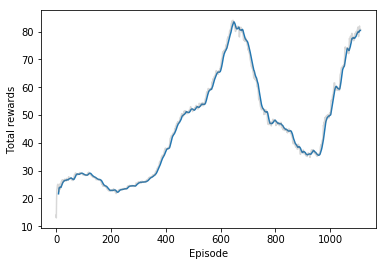

In [60]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

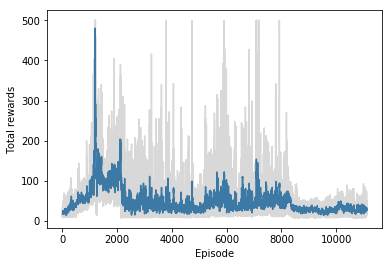

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

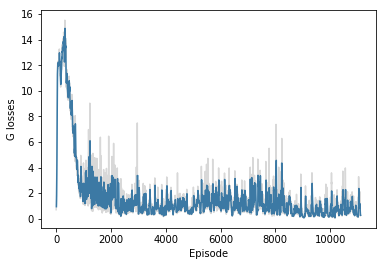

In [103]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

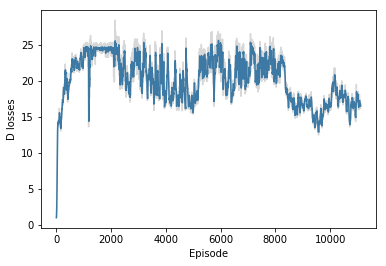

In [104]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.